## The steady Navir-Stokes equation
#### (1.1) The equation and the weak form
The governing PDE is
\begin{equation}
\begin{split}
 - \nu\nabla(\cdot \nabla {\bf u}) + \nabla p = {\bf f}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} = 0,\quad \text{in}\ \Omega
\end{split}
\end{equation}
where $p(N/m^2)$ is the pressure, ${\bf u} (m/s)$ is the velocity, $\nu$ is the dynamic viscosity, and ${\bf f}$ is the applied body force.
A typical set of boundary conditions on the boundary $\partial\Omega = \Gamma_D\cup \Gamma_N$ can be:
\begin{equation}
\begin{split}
 {\bf u} = {\bf u}_0, \quad \text{on}\ \Gamma_D \\
(\nabla\cdot{\bf u}+p)\cdot\vec{n} = g\quad \text{on}\ \Gamma_N
\end{split}
\end{equation}
### (1.2) The weal form
Given ${\bf f}\in H^{-1}(\Omega)$, find $({\bf u},p)\in H^1_0(\Omega)\times L^2_0(\Omega)$ such that
\begin{equation}
\begin{split}
(\nabla {\bf u}, \nabla {\bf v}) - (\nabla\cdot{\bf v}, p) &= <{\bf f}, {\bf v}>_{H^{-1}(\Omega), H^1_0(\Omega)},\quad \forall {\bf v}\in H^1_0(\Omega) \\
- (\nabla\cdot{\bf u}, q) &= 0,\quad \forall q\in L^2_0(\Omega)
\end{split}
\end{equation}
The above equation is equivalent to the following equation
\begin{equation}
(\nabla {\bf u}, \nabla {\bf v}) - (\nabla\cdot{\bf v}, p) + (\nabla\cdot{\bf u}, q) = <{\bf f}, {\bf v}>,\quad \forall ({\bf v},q)\in V\times Q
\end{equation}

### (1) The ParticleWNN 

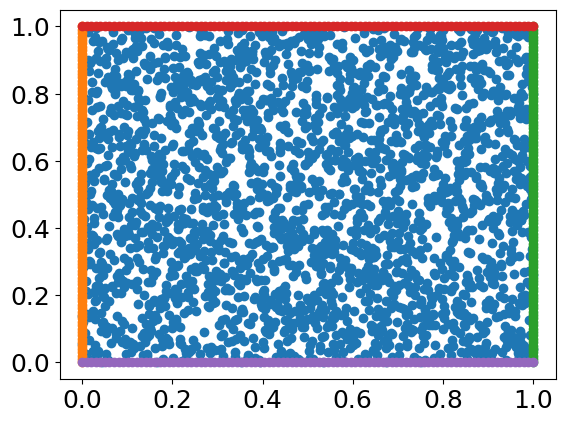

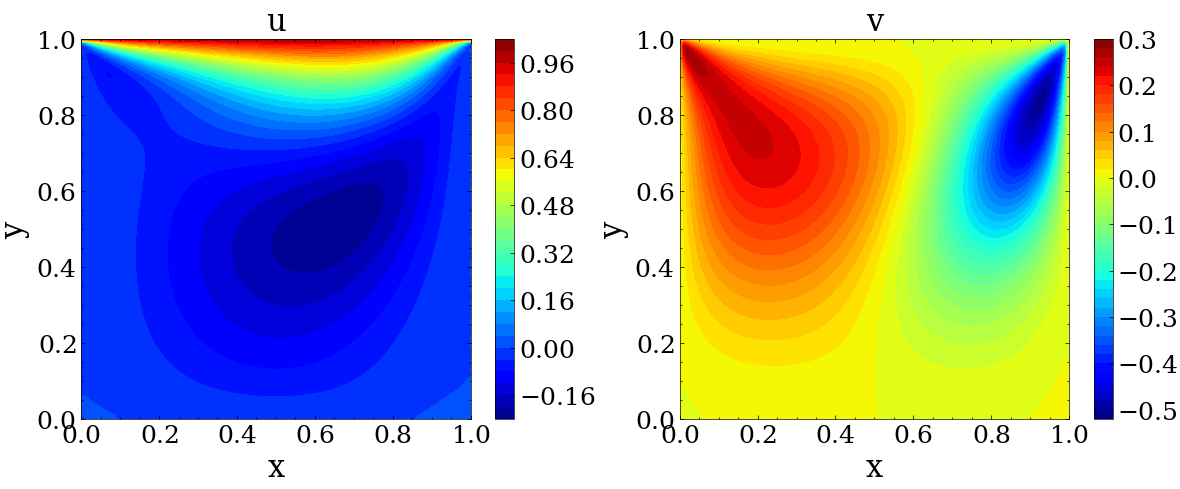

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch
from Utils.GenPoints import Point2D
from Utils.PlotFigure import Plot
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
device = 'cuda:0'
dtype = torch.float32
setup_seed(random_seed)
problem_name = 'NSteady_lid_cavity'
####################################
# Load data
####################################
data = h5py.File('../../Problems/NS_steady/truth_lid_cavity.mat', 'r')
u_test, v_test = np.array(data['u']), np.array(data['v'])
xx_test, yy_test = np.array(data['xx']).T, np.array(data['yy']).T
x_test = np.vstack((xx_test.flatten(), yy_test.flatten())).T
u_test = torch.tensor(u_test.reshape(-1,1), dtype=dtype)
v_test = torch.tensor(v_test.reshape(-1,1), dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
######################################
# Setups of the problem 
######################################
N_in, N_bd_each_edge = 2500, 100
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype, random_seed=random_seed)
# The inner points
xc_train, R_train = pointGen.weight_centers(n_center=N_in, R_max=1e-4, R_min=1e-4)
# The boundary points
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='mesh')
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#########################################
plt.figure()
plt.scatter(xc_train[...,0], xc_train[...,1])
plt.scatter(x_lt[:,0], x_lt[:,1])
plt.scatter(x_rt[:,0], x_rt[:,1])
plt.scatter(x_up[:,0], x_up[:,1])
plt.scatter(x_bt[:,0], x_bt[:,1])
plt.show()
#######################################
Plot.show_2d_list(x_test, [u_test, v_test],['u', 'v'])

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN

######################## 
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=8, 
    dataType=dtype).get_testFun()

class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_psip = solver.model_dict['psi_p']
        ######################## 
        self.int_grid = int_grid.to(self.solver.device)
        self.n_grid = int_grid.shape[0]
        self.phi = phi.to(self.solver.device)
        self.dphi_dr = dphi_dr.to(self.solver.device)
        #
        self.solver.getLoss = torch.nn.MSELoss()

    def get_values(self, x_device):
        psi_p = self.model_psip(x_device)
        psi, p = psi_p[...,0:1], psi_p[:,1:2]
        dpsi = self.solver.grad(psi, [x_device])[0]
        u, v = dpsi[...,1:2], -dpsi[...,0:1]
        
        return u, v, p

    def Loss_pde(self, xc=None, R=None, nu=0.01):
        xc, R = xc_train.to(self.device), R_train.to(self.device)
        nc = xc.shape[0]
        ##################################
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ##########################################
        phi = self.phi.repeat((nc,1,1)).reshape(-1,1)
        dphi = (self.dphi_dr / R).reshape(-1, 2)
        ###########################
        u, v, p = self.get_values(x)
        #
        du = self.solver.grad(u, [x])[0]
        dux, duy = du[...,0:1], du[...,1:2]
        dv = self.solver.grad(v, [x])[0]
        dvx, dvy = dv[...,0:1], dv[...,1:2]
        ###########################################
        res1 = (u*dux + v*duy) * phi - p * dphi[...,0:1] + nu * torch.sum( du * dphi, dim=-1, keepdim=True)
        res1 = torch.mean(res1.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        #
        res2 = (u*dvx + v*dvy) * phi - p * dphi[...,1:2] + nu * torch.sum( dv * dphi, dim=-1, keepdim=True)
        res2 = torch.mean(res2.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        ###############################
        xo = torch.tensor([[0., 0.]], dtype=self.dtype, device=self.device)
        psipo = self.model_psip(xo)
        po = psipo[...,1:]
        #
        loss = (self.solver.getLoss(res1, torch.zeros_like(res1)) + 
                self.solver.getLoss(res2, torch.zeros_like(res2)) +
                self.solver.getLoss(po, torch.zeros_like(po)))
        
        return loss

    def Loss_bd(self):
        loss = 0.
        #
        xup = Variable(x_up, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xup)
        loss += self.solver.getLoss(u, torch.ones_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))
        #
        xbt = Variable(x_bt, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xbt)
        loss += self.solver.getLoss(u, torch.zeros_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))
        #
        xlt = Variable(x_lt, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xlt)
        loss += self.solver.getLoss(u, torch.zeros_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))
        #
        xrt = Variable(x_rt, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xrt)
        loss += self.solver.getLoss(u, torch.zeros_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))

        return loss
        
    def Error(self):
        x = Variable(x_test, requires_grad=True).to(self.device)
        u_pred, v_pred, p_pred = self.get_values(x)
        #########
        error_u = self.solver.getError(u_pred, u_test.to(self.device))
        error_v = self.solver.getError(v_pred, v_test.to(self.device))
        #########
        error = [error_u, error_v]
        
        return error

# #####################################
# # Define the model
# #####################################
from Solvers.ParticleWNN import ParticleWNN
solver = ParticleWNN.Solver(device, dtype=dtype)
#################
psi_p_model = solver.getModel(layers_list=[2]+[40]*6+[2], activation='Tanh', netType='FCNet')

### (3) Training and prediction

#### (3.1) Train the model

In [3]:
model_dict = {'psi_p': psi_p_model}
solver.train_setup(model_dict, lr=1e-3, lr_lbfgs=1., optimizer='Adam', scheduler_type=None, 
                   lbfgs=True, max_iter=1000, history_size=10)
solver.train(LossClass, xc_train, R_train, batch_size_in=int(np.ceil(xc_train.shape[0]/10)), epochs=10000, 
             w_pde=1000., w_bd=50., **{'save_path':f'saved_models/'})
solver.train_lbfgs(LossClass, xc_train, R_train, epochs=200, 
                   w_pde=100., w_bd=5., **{'save_path':f'saved_models/'})

  1%|▍                                         | 100/10000 [00:23<37:57,  4.35it/s]

Epoch:100 Time:23.2438, loss_in:0.000373, loss_bd:0.053599
          lr: 0.001 l2_err [0.5166348814964294, 0.982958197593689]


  2%|▊                                         | 200/10000 [00:46<37:31,  4.35it/s]

Epoch:200 Time:46.1924, loss_in:0.000386, loss_bd:0.043608
          lr: 0.001 l2_err [0.4637255370616913, 0.9010607600212097]


  3%|█▎                                        | 300/10000 [01:09<37:17,  4.34it/s]

Epoch:300 Time:69.1693, loss_in:0.000351, loss_bd:0.035653
          lr: 0.001 l2_err [0.4308682680130005, 0.8714349865913391]


  4%|█▋                                        | 400/10000 [01:32<36:45,  4.35it/s]

Epoch:400 Time:92.1308, loss_in:0.000289, loss_bd:0.030872
          lr: 0.001 l2_err [0.3768911063671112, 0.7751726508140564]


  5%|██                                        | 500/10000 [01:55<36:16,  4.36it/s]

Epoch:500 Time:115.1004, loss_in:0.000238, loss_bd:0.027013
          lr: 0.001 l2_err [0.3501549959182739, 0.6929542422294617]


  6%|██▌                                       | 600/10000 [02:18<35:51,  4.37it/s]

Epoch:600 Time:138.0741, loss_in:0.000130, loss_bd:0.019250
          lr: 0.001 l2_err [0.22729872167110443, 0.3903471529483795]


  7%|██▉                                       | 700/10000 [02:41<35:31,  4.36it/s]

Epoch:700 Time:161.0030, loss_in:0.000094, loss_bd:0.016882
          lr: 0.001 l2_err [0.1930677592754364, 0.3249213993549347]


  8%|███▎                                      | 800/10000 [03:03<35:05,  4.37it/s]

Epoch:800 Time:183.9140, loss_in:0.000079, loss_bd:0.016696
          lr: 0.001 l2_err [0.16822406649589539, 0.291765034198761]


  9%|███▊                                      | 900/10000 [03:26<34:46,  4.36it/s]

Epoch:900 Time:206.8300, loss_in:0.000084, loss_bd:0.015235
          lr: 0.001 l2_err [0.15508154034614563, 0.27298712730407715]


 10%|████                                     | 1000/10000 [03:49<34:18,  4.37it/s]

Epoch:1000 Time:229.7404, loss_in:0.000083, loss_bd:0.014434
          lr: 0.001 l2_err [0.1493978649377823, 0.24981136620044708]


 11%|████▌                                    | 1100/10000 [04:12<34:02,  4.36it/s]

Epoch:1100 Time:252.6598, loss_in:0.000031, loss_bd:0.013671
          lr: 0.001 l2_err [0.1314677894115448, 0.2244725078344345]


 12%|████▉                                    | 1200/10000 [04:35<33:36,  4.37it/s]

Epoch:1200 Time:275.5737, loss_in:0.000111, loss_bd:0.014121
          lr: 0.001 l2_err [0.1274290680885315, 0.20600531995296478]


 13%|█████▎                                   | 1300/10000 [04:58<33:10,  4.37it/s]

Epoch:1300 Time:298.4832, loss_in:0.000126, loss_bd:0.015169
          lr: 0.001 l2_err [0.12396414577960968, 0.1920098215341568]


 14%|█████▋                                   | 1400/10000 [05:21<32:50,  4.36it/s]

Epoch:1400 Time:321.3985, loss_in:0.000126, loss_bd:0.013374
          lr: 0.001 l2_err [0.11189936846494675, 0.18028303980827332]


 15%|██████▏                                  | 1500/10000 [05:44<32:25,  4.37it/s]

Epoch:1500 Time:344.3016, loss_in:0.000107, loss_bd:0.013287
          lr: 0.001 l2_err [0.11236521601676941, 0.1770504266023636]


 16%|██████▌                                  | 1600/10000 [06:07<30:30,  4.59it/s]

Epoch:1600 Time:367.1529, loss_in:0.000031, loss_bd:0.012685
          lr: 0.001 l2_err [0.10308630019426346, 0.1683976948261261]


 17%|██████▉                                  | 1700/10000 [06:28<29:48,  4.64it/s]

Epoch:1700 Time:388.6863, loss_in:0.000019, loss_bd:0.012406
          lr: 0.001 l2_err [0.10118462145328522, 0.1622181385755539]


 18%|███████▍                                 | 1800/10000 [06:50<29:23,  4.65it/s]

Epoch:1800 Time:410.2068, loss_in:0.000018, loss_bd:0.012369
          lr: 0.001 l2_err [0.09621386229991913, 0.157180517911911]


 19%|███████▊                                 | 1900/10000 [07:11<29:02,  4.65it/s]

Epoch:1900 Time:431.7190, loss_in:0.000021, loss_bd:0.012062
          lr: 0.001 l2_err [0.09306331723928452, 0.1487932950258255]


 20%|████████▏                                | 2000/10000 [07:33<28:42,  4.65it/s]

Epoch:2000 Time:453.2331, loss_in:0.000112, loss_bd:0.012272
          lr: 0.001 l2_err [0.09369363635778427, 0.1530592143535614]


 21%|████████▌                                | 2100/10000 [07:54<28:18,  4.65it/s]

Epoch:2100 Time:474.7534, loss_in:0.000039, loss_bd:0.011900
          lr: 0.001 l2_err [0.09019038826227188, 0.14616285264492035]


 22%|█████████                                | 2200/10000 [08:16<27:57,  4.65it/s]

Epoch:2200 Time:496.2590, loss_in:0.000019, loss_bd:0.011975
          lr: 0.001 l2_err [0.09206268191337585, 0.13940581679344177]


 23%|█████████▍                               | 2300/10000 [08:37<27:38,  4.64it/s]

Epoch:2300 Time:517.7713, loss_in:0.000026, loss_bd:0.011728
          lr: 0.001 l2_err [0.08490250259637833, 0.1301136463880539]


 24%|█████████▊                               | 2400/10000 [08:59<27:17,  4.64it/s]

Epoch:2400 Time:539.2740, loss_in:0.000023, loss_bd:0.011844
          lr: 0.001 l2_err [0.08143554627895355, 0.12623848021030426]


 25%|██████████▎                              | 2500/10000 [09:20<26:54,  4.65it/s]

Epoch:2500 Time:560.7698, loss_in:0.000245, loss_bd:0.013070
          lr: 0.001 l2_err [0.07956147938966751, 0.11440384387969971]


 26%|██████████▋                              | 2600/10000 [09:42<26:31,  4.65it/s]

Epoch:2600 Time:582.2732, loss_in:0.000017, loss_bd:0.011475
          lr: 0.001 l2_err [0.0808129832148552, 0.11903980374336243]


 27%|███████████                              | 2700/10000 [10:03<26:09,  4.65it/s]

Epoch:2700 Time:603.7955, loss_in:0.000054, loss_bd:0.012554
          lr: 0.001 l2_err [0.08431229740381241, 0.13964904844760895]


 28%|███████████▍                             | 2800/10000 [10:25<25:48,  4.65it/s]

Epoch:2800 Time:625.3362, loss_in:0.000027, loss_bd:0.011738
          lr: 0.001 l2_err [0.08209992945194244, 0.12480434030294418]


 29%|███████████▉                             | 2900/10000 [10:46<25:27,  4.65it/s]

Epoch:2900 Time:646.8558, loss_in:0.000020, loss_bd:0.011856
          lr: 0.001 l2_err [0.07381171733140945, 0.10803751647472382]


 30%|████████████▎                            | 3000/10000 [11:08<25:06,  4.65it/s]

Epoch:3000 Time:668.3583, loss_in:0.000027, loss_bd:0.011569
          lr: 0.001 l2_err [0.07441223412752151, 0.10777590423822403]


 31%|████████████▋                            | 3100/10000 [11:29<24:44,  4.65it/s]

Epoch:3100 Time:689.8705, loss_in:0.000044, loss_bd:0.011252
          lr: 0.001 l2_err [0.0745466873049736, 0.10802962630987167]


 32%|█████████████                            | 3200/10000 [11:51<24:22,  4.65it/s]

Epoch:3200 Time:711.3804, loss_in:0.000040, loss_bd:0.011549
          lr: 0.001 l2_err [0.06865371018648148, 0.0957149788737297]


 33%|█████████████▌                           | 3300/10000 [12:12<23:59,  4.65it/s]

Epoch:3300 Time:732.8838, loss_in:0.000127, loss_bd:0.011800
          lr: 0.001 l2_err [0.06952216476202011, 0.09950919449329376]


 34%|█████████████▉                           | 3400/10000 [12:34<23:39,  4.65it/s]

Epoch:3400 Time:754.3881, loss_in:0.000029, loss_bd:0.011234
          lr: 0.001 l2_err [0.0670357495546341, 0.10091765224933624]


 35%|██████████████▎                          | 3500/10000 [12:55<23:16,  4.65it/s]

Epoch:3500 Time:775.8967, loss_in:0.000148, loss_bd:0.013066
          lr: 0.001 l2_err [0.07025329768657684, 0.10797923803329468]


 36%|██████████████▊                          | 3600/10000 [13:17<22:55,  4.65it/s]

Epoch:3600 Time:797.4058, loss_in:0.000024, loss_bd:0.011164
          lr: 0.001 l2_err [0.06829784065485, 0.09799256920814514]


 37%|███████████████▏                         | 3700/10000 [13:38<22:34,  4.65it/s]

Epoch:3700 Time:818.9130, loss_in:0.000045, loss_bd:0.011378
          lr: 0.001 l2_err [0.06657372415065765, 0.0985688790678978]


 38%|███████████████▌                         | 3800/10000 [14:00<22:15,  4.64it/s]

Epoch:3800 Time:840.4324, loss_in:0.000067, loss_bd:0.012345
          lr: 0.001 l2_err [0.0727880448102951, 0.10082244127988815]


 39%|███████████████▉                         | 3900/10000 [14:21<21:52,  4.65it/s]

Epoch:3900 Time:861.9375, loss_in:0.000063, loss_bd:0.011542
          lr: 0.001 l2_err [0.0707353800535202, 0.0961066484451294]


 40%|████████████████▍                        | 4000/10000 [14:43<21:30,  4.65it/s]

Epoch:4000 Time:883.4423, loss_in:0.000094, loss_bd:0.013261
          lr: 0.001 l2_err [0.08301129937171936, 0.11478635668754578]


 41%|████████████████▊                        | 4100/10000 [15:04<21:11,  4.64it/s]

Epoch:4100 Time:904.9595, loss_in:0.000013, loss_bd:0.010913
          lr: 0.001 l2_err [0.06014665216207504, 0.08333155512809753]


 42%|█████████████████▏                       | 4200/10000 [15:26<20:47,  4.65it/s]

Epoch:4200 Time:926.4667, loss_in:0.000065, loss_bd:0.012014
          lr: 0.001 l2_err [0.07992881536483765, 0.11968628317117691]


 43%|█████████████████▋                       | 4300/10000 [15:47<20:26,  4.65it/s]

Epoch:4300 Time:947.9666, loss_in:0.000088, loss_bd:0.011519
          lr: 0.001 l2_err [0.060454193502664566, 0.08653778582811356]


 44%|██████████████████                       | 4400/10000 [16:09<20:03,  4.65it/s]

Epoch:4400 Time:969.4842, loss_in:0.000066, loss_bd:0.011063
          lr: 0.001 l2_err [0.06158510223031044, 0.0825611799955368]


 45%|██████████████████▍                      | 4500/10000 [16:30<19:43,  4.65it/s]

Epoch:4500 Time:990.9915, loss_in:0.000013, loss_bd:0.010634
          lr: 0.001 l2_err [0.05839931592345238, 0.07883135229349136]


 46%|██████████████████▊                      | 4600/10000 [16:52<19:22,  4.65it/s]

Epoch:4600 Time:1012.5095, loss_in:0.000074, loss_bd:0.011654
          lr: 0.001 l2_err [0.061776284128427505, 0.09888114780187607]


 47%|███████████████████▎                     | 4700/10000 [17:14<19:00,  4.65it/s]

Epoch:4700 Time:1034.0185, loss_in:0.000042, loss_bd:0.010937
          lr: 0.001 l2_err [0.055443063378334045, 0.07601003348827362]


 48%|███████████████████▋                     | 4800/10000 [17:35<18:37,  4.65it/s]

Epoch:4800 Time:1055.5216, loss_in:0.000027, loss_bd:0.010790
          lr: 0.001 l2_err [0.05916426703333855, 0.07627949863672256]


 49%|████████████████████                     | 4900/10000 [17:57<18:16,  4.65it/s]

Epoch:4900 Time:1077.0246, loss_in:0.000024, loss_bd:0.010572
          lr: 0.001 l2_err [0.05553082376718521, 0.07222327589988708]


 50%|████████████████████▌                    | 5000/10000 [18:18<17:54,  4.65it/s]

Epoch:5000 Time:1098.5423, loss_in:0.000041, loss_bd:0.010622
          lr: 0.001 l2_err [0.055808279663324356, 0.07070998102426529]


 51%|████████████████████▉                    | 5100/10000 [18:40<17:35,  4.64it/s]

Epoch:5100 Time:1120.0530, loss_in:0.000013, loss_bd:0.010528
          lr: 0.001 l2_err [0.05427362397313118, 0.07087309658527374]


 52%|█████████████████████▎                   | 5200/10000 [19:01<17:12,  4.65it/s]

Epoch:5200 Time:1141.5608, loss_in:0.000042, loss_bd:0.010569
          lr: 0.001 l2_err [0.05660079047083855, 0.0734325498342514]


 53%|█████████████████████▋                   | 5300/10000 [19:23<16:50,  4.65it/s]

Epoch:5300 Time:1163.0680, loss_in:0.000011, loss_bd:0.010619
          lr: 0.001 l2_err [0.05200200527906418, 0.0647285059094429]


 54%|██████████████████████▏                  | 5400/10000 [19:44<16:30,  4.65it/s]

Epoch:5400 Time:1184.5765, loss_in:0.000143, loss_bd:0.012162
          lr: 0.001 l2_err [0.06918026506900787, 0.11400742083787918]


 55%|██████████████████████▌                  | 5500/10000 [20:06<16:09,  4.64it/s]

Epoch:5500 Time:1206.2155, loss_in:0.000072, loss_bd:0.010562
          lr: 0.001 l2_err [0.051679011434316635, 0.06564074754714966]


 56%|██████████████████████▉                  | 5600/10000 [20:27<15:47,  4.64it/s]

Epoch:5600 Time:1227.7600, loss_in:0.000022, loss_bd:0.010484
          lr: 0.001 l2_err [0.05088287591934204, 0.06360619515180588]


 57%|███████████████████████▎                 | 5700/10000 [20:49<15:26,  4.64it/s]

Epoch:5700 Time:1249.2995, loss_in:0.000039, loss_bd:0.010635
          lr: 0.001 l2_err [0.04917366802692413, 0.06317362189292908]


 58%|███████████████████████▊                 | 5800/10000 [21:10<15:04,  4.65it/s]

Epoch:5800 Time:1270.8422, loss_in:0.000024, loss_bd:0.010604
          lr: 0.001 l2_err [0.049221646040678024, 0.06107614189386368]


 59%|████████████████████████▏                | 5900/10000 [21:32<14:43,  4.64it/s]

Epoch:5900 Time:1292.3857, loss_in:0.000010, loss_bd:0.010500
          lr: 0.001 l2_err [0.049426835030317307, 0.060450229793787]


 60%|████████████████████████▌                | 6000/10000 [21:53<14:24,  4.63it/s]

Epoch:6000 Time:1313.9347, loss_in:0.000015, loss_bd:0.010657
          lr: 0.001 l2_err [0.051376812160015106, 0.06067190691828728]


 61%|█████████████████████████                | 6100/10000 [22:15<14:01,  4.64it/s]

Epoch:6100 Time:1335.4742, loss_in:0.000008, loss_bd:0.010383
          lr: 0.001 l2_err [0.04868379235267639, 0.05753811448812485]


 62%|█████████████████████████▍               | 6200/10000 [22:36<13:38,  4.64it/s]

Epoch:6200 Time:1357.0021, loss_in:0.000081, loss_bd:0.010872
          lr: 0.001 l2_err [0.05218333750963211, 0.06841978430747986]


 63%|█████████████████████████▊               | 6300/10000 [22:58<13:17,  4.64it/s]

Epoch:6300 Time:1378.5477, loss_in:0.000018, loss_bd:0.010374
          lr: 0.001 l2_err [0.0477328784763813, 0.05435274541378021]


 64%|██████████████████████████▏              | 6400/10000 [23:20<12:55,  4.64it/s]

Epoch:6400 Time:1400.0823, loss_in:0.000007, loss_bd:0.010363
          lr: 0.001 l2_err [0.048518385738134384, 0.0582982674241066]


 65%|██████████████████████████▋              | 6500/10000 [23:41<12:33,  4.64it/s]

Epoch:6500 Time:1421.6141, loss_in:0.000028, loss_bd:0.012337
          lr: 0.001 l2_err [0.07056356966495514, 0.11796071380376816]


 66%|███████████████████████████              | 6600/10000 [24:03<12:11,  4.65it/s]

Epoch:6600 Time:1443.1560, loss_in:0.000014, loss_bd:0.011082
          lr: 0.001 l2_err [0.05437709018588066, 0.06770971417427063]


 67%|███████████████████████████▍             | 6700/10000 [24:24<11:50,  4.64it/s]

Epoch:6700 Time:1464.6942, loss_in:0.000032, loss_bd:0.010684
          lr: 0.001 l2_err [0.04743385687470436, 0.05690642446279526]


 68%|███████████████████████████▉             | 6800/10000 [24:46<11:29,  4.64it/s]

Epoch:6800 Time:1486.2401, loss_in:0.000077, loss_bd:0.010956
          lr: 0.001 l2_err [0.048168376088142395, 0.0595560297369957]


 69%|████████████████████████████▎            | 6900/10000 [25:07<11:08,  4.63it/s]

Epoch:6900 Time:1507.7730, loss_in:0.000010, loss_bd:0.010327
          lr: 0.001 l2_err [0.04813041910529137, 0.056340541690588]


 70%|████████████████████████████▋            | 7000/10000 [25:29<10:45,  4.65it/s]

Epoch:7000 Time:1529.3057, loss_in:0.000005, loss_bd:0.010322
          lr: 0.001 l2_err [0.0474536195397377, 0.05518189072608948]


 71%|█████████████████████████████            | 7100/10000 [25:50<10:24,  4.64it/s]

Epoch:7100 Time:1550.8343, loss_in:0.000024, loss_bd:0.010485
          lr: 0.001 l2_err [0.052862148731946945, 0.06912124156951904]


 72%|█████████████████████████████▌           | 7200/10000 [26:12<10:03,  4.64it/s]

Epoch:7200 Time:1572.3778, loss_in:0.000015, loss_bd:0.010336
          lr: 0.001 l2_err [0.04567985609173775, 0.048679936677217484]


 73%|█████████████████████████████▉           | 7300/10000 [26:33<09:41,  4.64it/s]

Epoch:7300 Time:1593.9205, loss_in:0.000010, loss_bd:0.010322
          lr: 0.001 l2_err [0.04555220901966095, 0.048570092767477036]


 74%|██████████████████████████████▎          | 7400/10000 [26:55<09:19,  4.65it/s]

Epoch:7400 Time:1615.4416, loss_in:0.000013, loss_bd:0.011336
          lr: 0.001 l2_err [0.07131616026163101, 0.11146041750907898]


 75%|██████████████████████████████▊          | 7500/10000 [27:16<08:57,  4.65it/s]

Epoch:7500 Time:1636.9671, loss_in:0.000003, loss_bd:0.010307
          lr: 0.001 l2_err [0.04617489501833916, 0.050000451505184174]


 76%|███████████████████████████████▏         | 7600/10000 [27:38<08:36,  4.65it/s]

Epoch:7600 Time:1658.4783, loss_in:0.000003, loss_bd:0.010300
          lr: 0.001 l2_err [0.04721399396657944, 0.052414681762456894]


 77%|███████████████████████████████▌         | 7700/10000 [28:00<08:16,  4.63it/s]

Epoch:7700 Time:1680.0192, loss_in:0.000009, loss_bd:0.010254
          lr: 0.001 l2_err [0.045612286776304245, 0.05044739320874214]


 78%|███████████████████████████████▉         | 7800/10000 [28:21<07:53,  4.65it/s]

Epoch:7800 Time:1701.5401, loss_in:0.000032, loss_bd:0.010690
          lr: 0.001 l2_err [0.048206765204668045, 0.05191529169678688]


 79%|████████████████████████████████▍        | 7900/10000 [28:43<07:31,  4.65it/s]

Epoch:7900 Time:1723.0649, loss_in:0.000010, loss_bd:0.010299
          lr: 0.001 l2_err [0.047315072268247604, 0.05746318772435188]


 80%|████████████████████████████████▊        | 8000/10000 [29:04<07:10,  4.64it/s]

Epoch:8000 Time:1744.5876, loss_in:0.000005, loss_bd:0.010272
          lr: 0.001 l2_err [0.04685705155134201, 0.05107558146119118]


 81%|█████████████████████████████████▏       | 8100/10000 [29:26<06:48,  4.65it/s]

Epoch:8100 Time:1766.1055, loss_in:0.000031, loss_bd:0.010386
          lr: 0.001 l2_err [0.04706321656703949, 0.04917069524526596]


 82%|█████████████████████████████████▌       | 8200/10000 [29:47<06:27,  4.64it/s]

Epoch:8200 Time:1787.6227, loss_in:0.000005, loss_bd:0.010353
          lr: 0.001 l2_err [0.04610620066523552, 0.05173061415553093]


 83%|██████████████████████████████████       | 8300/10000 [30:09<06:05,  4.65it/s]

Epoch:8300 Time:1809.1681, loss_in:0.000008, loss_bd:0.010248
          lr: 0.001 l2_err [0.04505698010325432, 0.052941154688596725]


 84%|██████████████████████████████████▍      | 8400/10000 [30:30<05:44,  4.65it/s]

Epoch:8400 Time:1830.6979, loss_in:0.000015, loss_bd:0.010210
          lr: 0.001 l2_err [0.04405924677848816, 0.04812542721629143]


 85%|██████████████████████████████████▊      | 8500/10000 [30:52<05:22,  4.64it/s]

Epoch:8500 Time:1852.2246, loss_in:0.000149, loss_bd:0.014214
          lr: 0.001 l2_err [0.06025638431310654, 0.08562971651554108]


 86%|███████████████████████████████████▎     | 8600/10000 [31:13<05:01,  4.64it/s]

Epoch:8600 Time:1873.7522, loss_in:0.000013, loss_bd:0.010414
          lr: 0.001 l2_err [0.0451783612370491, 0.05361757054924965]


 87%|███████████████████████████████████▋     | 8700/10000 [31:35<04:40,  4.64it/s]

Epoch:8700 Time:1895.2927, loss_in:0.000037, loss_bd:0.010819
          lr: 0.001 l2_err [0.04820172116160393, 0.06351983547210693]


 88%|████████████████████████████████████     | 8800/10000 [31:56<04:18,  4.65it/s]

Epoch:8800 Time:1916.8222, loss_in:0.000096, loss_bd:0.016656
          lr: 0.001 l2_err [0.08823676407337189, 0.15325041115283966]


 89%|████████████████████████████████████▍    | 8900/10000 [32:18<03:57,  4.64it/s]

Epoch:8900 Time:1938.3590, loss_in:0.000016, loss_bd:0.011015
          lr: 0.001 l2_err [0.05126449093222618, 0.08481264859437943]


 90%|████████████████████████████████████▉    | 9000/10000 [32:39<03:35,  4.65it/s]

Epoch:9000 Time:1959.8767, loss_in:0.000003, loss_bd:0.010200
          lr: 0.001 l2_err [0.044200051575899124, 0.04749564826488495]


 91%|█████████████████████████████████████▎   | 9100/10000 [33:01<03:14,  4.64it/s]

Epoch:9100 Time:1981.4028, loss_in:0.000006, loss_bd:0.010183
          lr: 0.001 l2_err [0.04404124617576599, 0.04362419620156288]


 92%|█████████████████████████████████████▋   | 9200/10000 [33:22<02:52,  4.65it/s]

Epoch:9200 Time:2002.9247, loss_in:0.000037, loss_bd:0.010307
          lr: 0.001 l2_err [0.044070061296224594, 0.04537089541554451]


 93%|██████████████████████████████████████▏  | 9300/10000 [33:44<02:30,  4.65it/s]

Epoch:9300 Time:2024.4507, loss_in:0.000014, loss_bd:0.010647
          lr: 0.001 l2_err [0.04297132417559624, 0.0451422855257988]


 94%|██████████████████████████████████████▌  | 9400/10000 [34:05<02:09,  4.64it/s]

Epoch:9400 Time:2045.9832, loss_in:0.000004, loss_bd:0.010363
          lr: 0.001 l2_err [0.04959788918495178, 0.05905228108167648]


 95%|██████████████████████████████████████▉  | 9500/10000 [34:27<01:48,  4.60it/s]

Epoch:9500 Time:2067.5188, loss_in:0.000025, loss_bd:0.012365
          lr: 0.001 l2_err [0.06320887058973312, 0.10147234052419662]


 96%|███████████████████████████████████████▎ | 9600/10000 [34:49<01:26,  4.64it/s]

Epoch:9600 Time:2089.0746, loss_in:0.000007, loss_bd:0.010240
          lr: 0.001 l2_err [0.04435377195477486, 0.04806072637438774]


 97%|███████████████████████████████████████▊ | 9700/10000 [35:10<01:04,  4.64it/s]

Epoch:9700 Time:2110.6104, loss_in:0.000018, loss_bd:0.010388
          lr: 0.001 l2_err [0.046066492795944214, 0.05653049796819687]


 98%|████████████████████████████████████████▏| 9800/10000 [35:32<00:43,  4.64it/s]

Epoch:9800 Time:2132.1503, loss_in:0.000013, loss_bd:0.010205
          lr: 0.001 l2_err [0.04487515613436699, 0.04405531287193298]


 99%|████████████████████████████████████████▌| 9900/10000 [35:53<00:21,  4.64it/s]

Epoch:9900 Time:2153.6878, loss_in:0.000008, loss_bd:0.010524
          lr: 0.001 l2_err [0.05049588531255722, 0.06694960594177246]


100%|████████████████████████████████████████| 10000/10000 [36:15<00:00,  4.60it/s]


Epoch:10000 Time:2175.2294, loss_in:0.000014, loss_bd:0.010171
          lr: 0.001 l2_err [0.04360543191432953, 0.045126721262931824]
The total training time is 2175.2901
****************** The training with LBFGS optimizer ***********


  2%|█▏                                            | 5/200 [01:16<53:25, 16.44s/it]

Epoch:5 Time:2251.7575, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043908167630434036, 0.0422530397772789]


  8%|███▌                                         | 16/200 [01:56<07:29,  2.45s/it]

Epoch:10 Time:2292.0976, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:15 Time:2292.2393, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 12%|█████▍                                       | 24/200 [01:57<02:44,  1.07it/s]

Epoch:20 Time:2292.3806, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:25 Time:2292.5228, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 18%|████████                                     | 36/200 [01:57<00:49,  3.34it/s]

Epoch:30 Time:2292.6647, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:35 Time:2292.8062, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 22%|█████████▉                                   | 44/200 [01:57<00:24,  6.38it/s]

Epoch:40 Time:2292.9476, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:45 Time:2293.0899, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 28%|████████████▌                                | 56/200 [01:58<00:10, 13.99it/s]

Epoch:50 Time:2293.2312, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:55 Time:2293.3724, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 32%|██████████████▍                              | 64/200 [01:58<00:06, 20.26it/s]

Epoch:60 Time:2293.5136, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:65 Time:2293.6561, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 38%|█████████████████                            | 76/200 [01:58<00:04, 28.18it/s]

Epoch:70 Time:2293.7971, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:75 Time:2293.9384, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 42%|██████████████████▉                          | 84/200 [01:58<00:03, 31.41it/s]

Epoch:80 Time:2294.0797, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:85 Time:2294.2222, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 48%|█████████████████████▌                       | 96/200 [01:59<00:03, 33.88it/s]

Epoch:90 Time:2294.3633, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:95 Time:2294.5047, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 52%|██████████████████████▉                     | 104/200 [01:59<00:02, 34.62it/s]

Epoch:100 Time:2294.6459, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:105 Time:2294.7882, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 58%|█████████████████████████▌                  | 116/200 [01:59<00:02, 35.03it/s]

Epoch:110 Time:2294.9300, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:115 Time:2295.0716, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 62%|███████████████████████████▎                | 124/200 [02:00<00:02, 35.14it/s]

Epoch:120 Time:2295.2135, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:125 Time:2295.3557, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 68%|█████████████████████████████▉              | 136/200 [02:00<00:01, 35.24it/s]

Epoch:130 Time:2295.4970, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:135 Time:2295.6386, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 72%|███████████████████████████████▋            | 144/200 [02:00<00:01, 35.29it/s]

Epoch:140 Time:2295.7799, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:145 Time:2295.9221, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 78%|██████████████████████████████████▎         | 156/200 [02:00<00:01, 35.27it/s]

Epoch:150 Time:2296.0639, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:155 Time:2296.2055, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 82%|████████████████████████████████████        | 164/200 [02:01<00:01, 35.27it/s]

Epoch:160 Time:2296.3470, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:165 Time:2296.4894, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 88%|██████████████████████████████████████▋     | 176/200 [02:01<00:00, 35.32it/s]

Epoch:170 Time:2296.6307, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:175 Time:2296.7719, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 92%|████████████████████████████████████████▍   | 184/200 [02:01<00:00, 35.33it/s]

Epoch:180 Time:2296.9132, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:185 Time:2297.0554, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


 98%|███████████████████████████████████████████ | 196/200 [02:02<00:00, 35.28it/s]

Epoch:190 Time:2297.1973, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
Epoch:195 Time:2297.3388, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]


100%|████████████████████████████████████████████| 200/200 [02:02<00:00,  1.64it/s]

Epoch:200 Time:2297.4802, loss_in:0.000002, loss_bd:0.010080
           lr_lbfgs: 1.0 l2_err [0.043898262083530426, 0.04221397265791893]
The total training time is 2297.5428


#### (3.2) Make prediction

The l2 error u is: tensor([0.0439])
The l2 error v is: tensor([0.0422])


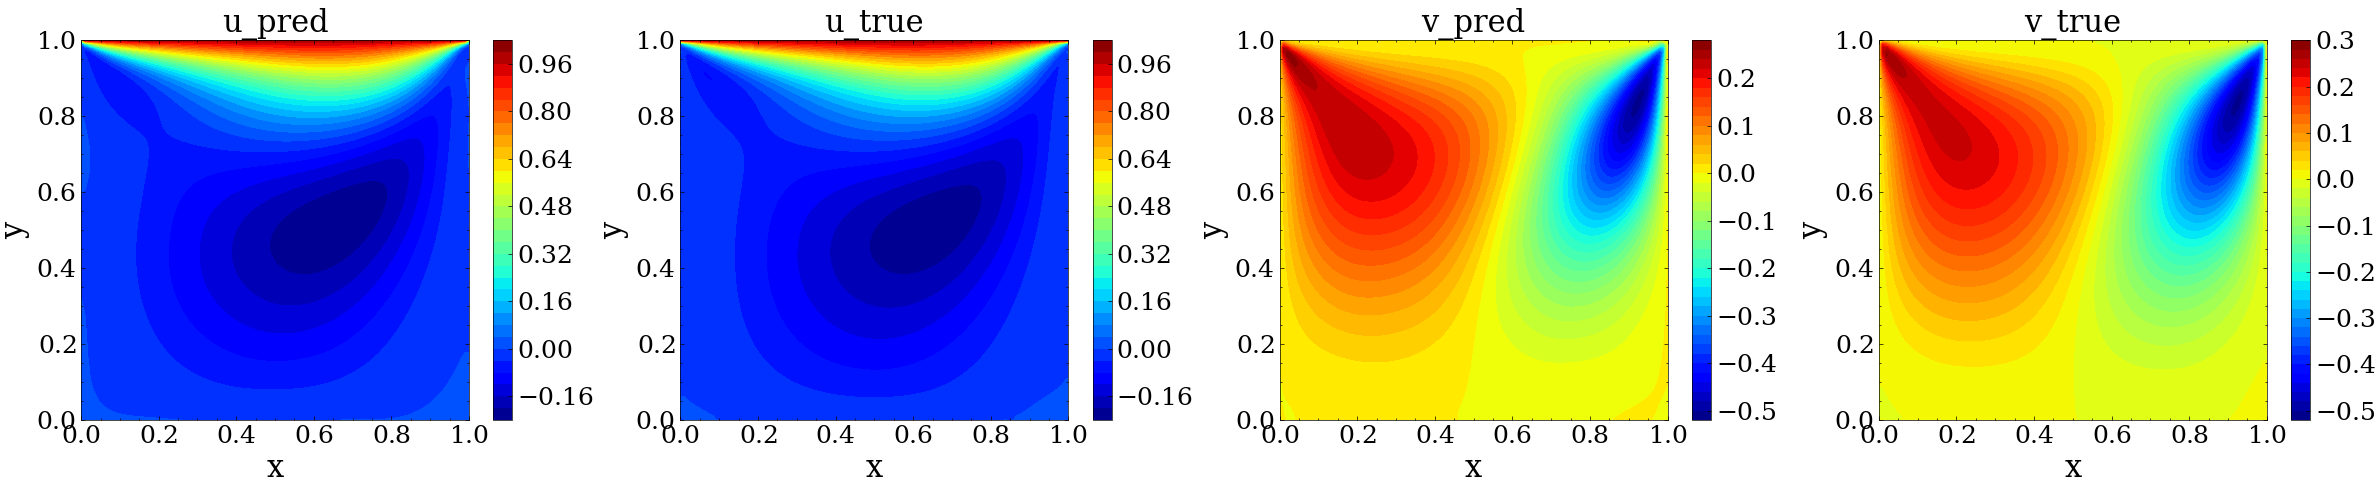

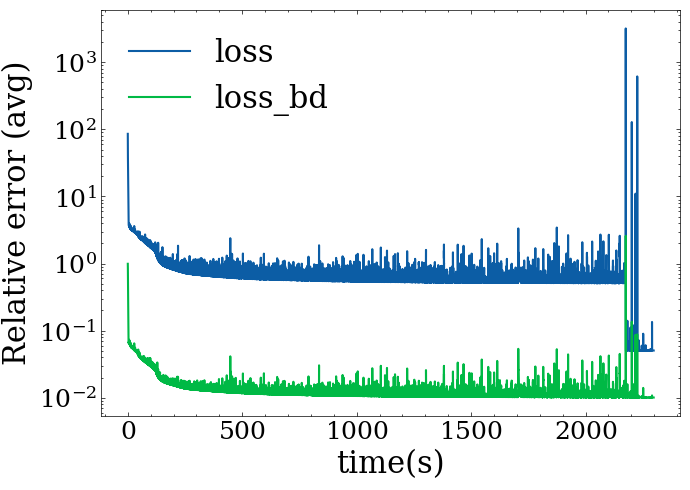

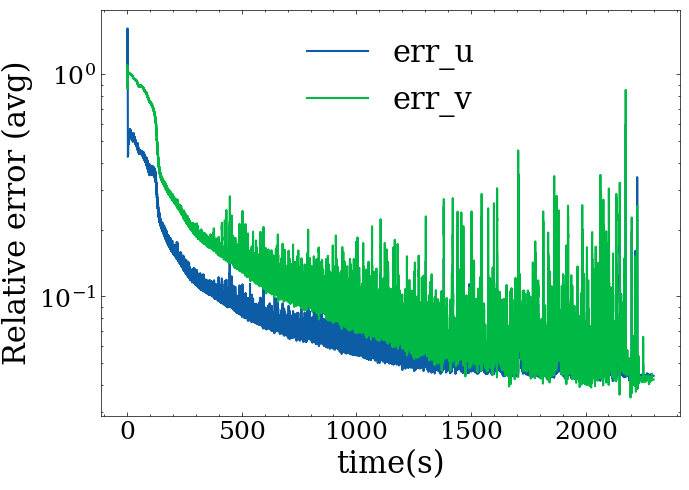

In [3]:
from torch.autograd import Variable
from Utils.PlotFigure import Plot
from Utils.Losses import *
from Solvers.ParticleWNN import ParticleWNN
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = ParticleWNN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_particlewnn_bestloss')

###############################
# make prediction
###############################
def get_values(x_device, solver, model_psip):
    psi_p = model_psip(x_device)
    psi, p = psi_p[...,0:1], psi_p[:,1:2]
    dpsi = solver.grad(psi, [x_device])[0]
    u, v = dpsi[...,1:2], -dpsi[...,0:1]
    
    return u, v, p
#
x_pred = Variable(x_test.to(device), requires_grad=True)
u_pred, v_pred, p_pred = get_values(x_pred, solver, model_trained['psi_p'])
u_pred = u_pred.detach().cpu()
v_pred = v_pred.detach().cpu()
p_pred = p_pred.detach().cpu()
#
print('The l2 error u is:', myerror(u_pred, u_test))
print('The l2 error v is:', myerror(v_pred, v_test))
######################################################
# show the solution
Plot.show_2d_list(x_test, [u_pred, u_test, v_pred, v_test], ['u_pred', 'u_true', 'v_pred', 'v_true'])
# show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*2, 
                [loss_saved['loss'],  loss_saved['loss_bd']],['loss', 'loss_bd'])
# show the error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], ['err_u', 'err_v'])